# News Article Image Tagging System

This notebook implements an MVP for an image tagging system that associates relevant images from a library with news articles based on semantic similarity using CLIP embeddings and FAISS vector search.

## Setup and Dependencies

In [3]:
# Install required packages
!pip install transformers pillow pandas numpy scikit-learn faiss-cpu torch tqdm matplotlib

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import time
import pandas as pd
import numpy as np
import torch
import faiss
from PIL import Image
from tqdm.notebook import tqdm
from transformers import CLIPProcessor, CLIPModel
from sklearn.cluster import KMeans
import re
import json
from pathlib import Path
import pickle
import warnings
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image as IPImage
warnings.filterwarnings('ignore')

## Configuration

Set up paths and parameters for the system. Modify these settings to match your Google Drive structure and requirements.

In [5]:
# Configuration
class Config:
    # Paths (update these according to your Google Drive structure)
    DRIVE_BASE = '/content/drive/MyDrive'

    DRIVE_FILE_FOLDER_ID = '1acPvJgQsLtEfMD1cAwqzOgelPu2hnsMP'

    NEWS_CSV = f'{DRIVE_BASE}/Image Tagging/news.csv'  # News articles CSV
    OUTPUT_DIR = f'{DRIVE_BASE}/Image Tagging/image_tagging_output'  # Output directory

    # Model parameters
    CLIP_MODEL = "openai/clip-vit-base-patch32"  # CLIP model to use
    BATCH_SIZE = 32  # Batch size for processing
    MAX_TEXT_LENGTH = 77  # Maximum token length for article text

    # Matching parameters
    SIMILARITY_THRESHOLD = 0.25  # Minimum similarity score to consider a match
    TOP_K_RETRIEVAL = 20  # Number of top candidates to retrieve from FAISS
    MAX_IMAGES_PER_ARTICLE = 3  # Maximum number of images to return per article

    # Article text fields (modify based on your CSV structure)
    TITLE_FIELD = 'title'  # Column name for article title
    BODY_FIELD = 'content'    # Column name for article body text
    ID_FIELD = 'newsId'        # Column name for article ID

    # Device configuration
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create output directory if it doesn't exist
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

In [6]:
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import os

# Authenticate and create the Drive API client
auth.authenticate_user()
drive_service = build('drive', 'v3')

def list_files_in_folder(folder_id):
    """List all files in a Google Drive folder."""
    results = []
    page_token = None

    while True:
        response = drive_service.files().list(
            q=f"'{folder_id}' in parents and trashed=false",
            spaces='drive',
            fields='nextPageToken, files(id, name, mimeType)',
            pageToken=page_token
        ).execute()

        for file in response.get('files', []):
            results.append(file)

        page_token = response.get('nextPageToken', None)
        if page_token is None:
            break

    return results

# The folder ID from your Google Drive URL
shared_folder_id = '1acPvJgQsLtEfMD1cAwqzOgelPu2hnsMP'

# List files in the folder
files = list_files_in_folder(shared_folder_id)
print(f"Found {len(files)} items in the shared folder")

# Print some information about the files
for file in files[:5]:  # Show first 5 items
    print(f"Name: {file['name']}, Type: {file['mimeType']}, ID: {file['id']}")

Found 30 items in the shared folder
Name: aluminium|aluminum|alumina, Type: application/vnd.google-apps.folder, ID: 1D1qjT6rU1g5krtc8Winu43oH1Yqn4q0g
Name: copper|copper cathode|copper wire, Type: application/vnd.google-apps.folder, ID: 1qt11ahu5fOgzPF1HLTUEMnZ7RtcbmjzK
Name: roads|highway, Type: application/vnd.google-apps.folder, ID: 1TjU6YusN7zL50Ej04JWneeyWIX6G_4JJ
Name: lead|lead ingot, Type: application/vnd.google-apps.folder, ID: 1JRj_WOgA7MtJUewKrmouDfpJXdmNtKEa
Name: port shipment|shipping|cargo, Type: application/vnd.google-apps.folder, ID: 100gQR7jVf1ioZ3iucaR0gCwXzJN0L7Yq


## Helper Functions

Define utility functions for text cleaning and similarity calculation.

In [7]:
def clean_text(text):
    """Clean article text by removing HTML tags and special characters."""
    if not isinstance(text, str):
        return ""

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and extra whitespace
    text = re.sub(r'[^\w\s.,!?\'\"\-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def cosine_similarity(a, b):
    """Calculate cosine similarity between two vectors."""
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Create a function to find images from Google Drive

def find_all_images_from_drive(folder_id, local_cache_dir=None):
    """Find all image files in a Google Drive folder and its subfolders with multithreaded downloading."""
    from google.colab import auth
    from googleapiclient.discovery import build
    import io, os
    from googleapiclient.http import MediaIoBaseDownload
    import concurrent.futures
    import threading
    import time
    from tqdm.notebook import tqdm

    # Authenticate if not already done
    try:
        drive_service
    except NameError:
        auth.authenticate_user()
        drive_service = build('drive', 'v3')

    print("Starting multithreaded image discovery and download process...")
    image_metadata = []
    image_extensions = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG', '.gif', '.GIF')

    # Create local cache directory if needed
    if local_cache_dir:
        os.makedirs(local_cache_dir, exist_ok=True)

    # Thread-safe counter for statistics
    class Counter:
        def __init__(self):
            self.value = 0
            self.lock = threading.Lock()

        def increment(self):
            with self.lock:
                self.value += 1
                return self.value

    download_counter = Counter()
    folder_counter = Counter()

    # Thread-safe progress bar
    progress_lock = threading.Lock()

    # Function to download a single file
    def download_file(file_id, local_path, relative_path, folder_name, file_name):
        try:
            if os.path.exists(local_path):
                # File already exists, no need to download
                with progress_lock:
                    current = download_counter.increment()
                return {
                    "path": relative_path,
                    "local_path": local_path,
                    "folder_name": folder_name,
                    "file_name": file_name,
                    "metadata_text": f"{folder_name} {file_name}"
                }

            # Create parent directory if it doesn't exist
            os.makedirs(os.path.dirname(local_path), exist_ok=True)

            # Download the file
            request = drive_service.files().get_media(fileId=file_id)
            fh = io.FileIO(local_path, 'wb')
            downloader = MediaIoBaseDownload(fh, request)
            done = False

            while not done:
                status, done = downloader.next_chunk()

            with progress_lock:
                current = download_counter.increment()
                if current % 10 == 0:  # Update every 10 files
                    print(f"Downloaded {current} files")

            return {
                "path": relative_path,
                "local_path": local_path,
                "folder_name": folder_name,
                "file_name": file_name,
                "metadata_text": f"{folder_name} {file_name}"
            }
        except Exception as e:
            print(f"Error downloading {file_name}: {str(e)}")
            return None

    # Function to discover all image files in a folder recursively
    def discover_images_in_folder(folder_id, relative_path):
        discovered_files = []
        download_tasks = []

        try:
            # Get all files in the current folder
            items = []
            page_token = None

            while True:
                response = drive_service.files().list(
                    q=f"'{folder_id}' in parents and trashed=false",
                    spaces='drive',
                    fields='nextPageToken, files(id, name, mimeType)',
                    pageToken=page_token
                ).execute()

                items.extend(response.get('files', []))
                page_token = response.get('nextPageToken')

                if not page_token:
                    break

            # Process folders first to discover all potential files
            subfolders = []
            for item in items:
                if item['mimeType'] == 'application/vnd.google-apps.folder':
                    subfolder_name = item['name']
                    subfolder_id = item['id']
                    new_path = os.path.join(relative_path, subfolder_name)
                    subfolders.append((subfolder_id, new_path))

            # Process all subfolders recursively
            for subfolder_id, subfolder_path in subfolders:
                folder_counter.increment()
                subfolder_files = discover_images_in_folder(subfolder_id, subfolder_path)
                discovered_files.extend(subfolder_files)

            # Process image files in the current folder
            for item in items:
                if item['mimeType'] != 'application/vnd.google-apps.folder' and item['name'].lower().endswith(image_extensions):
                    file_id = item['id']
                    file_name = item['name']
                    full_relative_path = os.path.join(relative_path, file_name)
                    folder_name = os.path.basename(relative_path) if relative_path else "root"

                    if local_cache_dir:
                        local_path = os.path.join(local_cache_dir, full_relative_path)

                        # Add to download queue
                        download_tasks.append((file_id, local_path, full_relative_path, folder_name, file_name))
                    else:
                        # Just record metadata without downloading
                        discovered_files.append({
                            "path": full_relative_path,
                            "file_id": file_id,
                            "folder_name": folder_name,
                            "file_name": file_name,
                            "metadata_text": f"{folder_name} {file_name}"
                        })

            return discovered_files, download_tasks

        except Exception as e:
            print(f"Error exploring folder {folder_id}: {str(e)}")
            return [], []

    # First phase: Discover all files (without downloading)
    print("Phase 1: Discovering all image files in Google Drive...")
    start_time = time.time()
    discovered_files, download_tasks = discover_images_in_folder(folder_id, '')
    discovery_time = time.time() - start_time

    print(f"Discovery completed in {discovery_time:.2f} seconds.")
    print(f"Found {len(download_tasks)} images in {folder_counter.value} folders.")

    # If we're not downloading, return the discovered files
    if not local_cache_dir:
        return discovered_files

    # Second phase: Download files using a thread pool
    print(f"Phase 2: Downloading {len(download_tasks)} images using multiple threads...")
    start_time = time.time()

    # Create a progress bar
    progress_bar = tqdm(total=len(download_tasks), desc="Downloading images")

    # Thread-safe update for progress bar
    def update_progress():
        with progress_lock:
            progress_bar.update(1)

    # Set up multithreaded downloading
    max_workers = min(32, len(download_tasks))  # Limit number of threads
    if max_workers == 0:
        print("No files to download.")
        return discovered_files

    print(f"Using {max_workers} threads for parallel downloads")

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all download tasks
        future_to_task = {}
        for task in download_tasks:
            file_id, local_path, relative_path, folder_name, file_name = task
            future = executor.submit(download_file, file_id, local_path, relative_path, folder_name, file_name)
            future_to_task[future] = task

        # Process results as they complete
        for future in concurrent.futures.as_completed(future_to_task):
            task = future_to_task[future]
            try:
                metadata = future.result()
                if metadata:
                    image_metadata.append(metadata)
                update_progress()
            except Exception as e:
                file_id, local_path, _, _, file_name = task
                print(f"Error downloading {file_name}: {str(e)}")
                update_progress()

    progress_bar.close()

    # Combine discovered files that weren't downloaded with downloaded file metadata
    for file in discovered_files:
        if 'file_id' in file:  # This indicates it wasn't downloaded
            image_metadata.append(file)

    download_time = time.time() - start_time
    print(f"Download completed in {download_time:.2f} seconds.")
    print(f"Successfully processed {len(image_metadata)} images.")

    # Save a mapping file for easier debugging
    if local_cache_dir and image_metadata:
        import json
        mapping = {i: metadata for i, metadata in enumerate(image_metadata)}
        mapping_file = os.path.join(os.path.dirname(local_cache_dir), "image_mapping.json")
        with open(mapping_file, 'w') as f:
            json.dump(mapping, f, indent=2)
        print(f"Image mapping saved to {mapping_file}")

    return image_metadata

## 1. Image Preprocessing Pipeline

Load images from Google Drive and generate CLIP embeddings.

In [ ]:
def load_clip_model():
    """Load the CLIP model and processor."""
    model = CLIPModel.from_pretrained(Config.CLIP_MODEL).to(Config.DEVICE)
    processor = CLIPProcessor.from_pretrained(Config.CLIP_MODEL)
    return model, processor

def generate_image_embeddings_with_metadata(model, processor, image_metadata):
    """Generate CLIP embeddings for images, incorporating metadata from folder and filenames using concatenation."""
    import torch
    import numpy as np
    from PIL import Image
    from tqdm.notebook import tqdm

    image_ids = []
    visual_embeddings = []
    text_embeddings = []
    concatenated_embeddings = []
    failed_images = []

    # Process images in batches
    for i in tqdm(range(0, len(image_metadata), Config.BATCH_SIZE), desc="Generating image embeddings"):
        batch_metadata = image_metadata[i:i + Config.BATCH_SIZE]
        batch_images = []
        batch_texts = []
        batch_ids = []

        # Load images and prepare text descriptions for this batch
        for metadata in batch_metadata:
            try:
                img_path = metadata["local_path"]
                image = Image.open(img_path).convert('RGB')
                batch_images.append(image)

                # Create text description from folder and file name
                folder_name = metadata.get("folder_name", "")
                file_name = metadata.get("file_name", "")
                text_description = f"{folder_name} {file_name}"
                batch_texts.append(text_description)

                # Store metadata for reference
                batch_ids.append(metadata)
            except Exception as e:
                failed_images.append((metadata, str(e)))
                continue

        if not batch_images:
            continue

        # Process batch through CLIP for images and text separately
        with torch.no_grad():
            # Get image embeddings
            image_inputs = processor(images=batch_images, return_tensors="pt", padding=True).to(Config.DEVICE)
            image_outputs = model.get_image_features(**image_inputs)
            batch_visual_embeddings = image_outputs.cpu().numpy()

            # Get text embeddings for the metadata
            text_inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True,
                                   max_length=77).to(Config.DEVICE)
            text_outputs = model.get_text_features(**text_inputs)
            batch_text_embeddings = text_outputs.cpu().numpy()

            # Normalize individual embeddings
            batch_visual_embeddings = batch_visual_embeddings / np.linalg.norm(batch_visual_embeddings, axis=1, keepdims=True)
            batch_text_embeddings = batch_text_embeddings / np.linalg.norm(batch_text_embeddings, axis=1, keepdims=True)

            # Concatenate the embeddings
            batch_concatenated = np.concatenate([batch_visual_embeddings, batch_text_embeddings], axis=1)

        # Add to the collection
        image_ids.extend(batch_ids)
        visual_embeddings.append(batch_visual_embeddings)
        text_embeddings.append(batch_text_embeddings)
        concatenated_embeddings.append(batch_concatenated)

    # Combine all batches
    if visual_embeddings:
        visual_embeddings = np.vstack(visual_embeddings)
        text_embeddings = np.vstack(text_embeddings)
        concatenated_embeddings = np.vstack(concatenated_embeddings)
    else:
        visual_embeddings = np.array([])
        text_embeddings = np.array([])
        concatenated_embeddings = np.array([])

    # Log failures
    print(f"Successfully processed {len(image_ids)} images. Failed to process {len(failed_images)} images.")
    print(f"Shape of concatenated embeddings: {concatenated_embeddings.shape}")

    return image_ids, visual_embeddings, text_embeddings, concatenated_embeddings, failed_images


def build_faiss_index(embeddings):
    """Build a FAISS index for fast similarity search."""
    import faiss

    # Check if embeddings array is empty
    if embeddings is None or len(embeddings) == 0:
        print("Warning: No embeddings to index.")
        return None

    dimension = embeddings.shape[1]
    print(f"Building FAISS index with dimension: {dimension}")

    # Use inner product (since vectors are normalized, equivalent to cosine similarity)
    index = faiss.IndexFlatIP(dimension)
    index.add(embeddings.astype('float32'))

    print(f"FAISS index built with {index.ntotal} vectors")
    return index

def process_image_library():
    """Process the entire image library with enhanced metadata and concatenated embeddings."""
    import os
    import pickle
    import json
    import numpy as np
    import faiss
    from tqdm.notebook import tqdm

    print(f"Finding images in shared Drive folder...")

    # Create a local cache directory for downloaded images
    cache_dir = '/tmp/image_cache'
    os.makedirs(cache_dir, exist_ok=True)

    # Find all images in the folder and its subfolders with metadata
    image_metadata = find_all_images_from_drive(Config.DRIVE_FILE_FOLDER_ID, cache_dir)
    print(f"Found {len(image_metadata)} images")

    # Handle the case where the top-level folder is empty (contains only subfolders)
    if len(image_metadata) == 0:
        print("No images found at the top level. Checking subfolders...")
        # Get subfolders
        subfolders = list_files_in_folder(Config.DRIVE_FILE_FOLDER_ID)
        subfolder_ids = [f['id'] for f in subfolders if f['mimeType'] == 'application/vnd.google-apps.folder']

        all_image_metadata = []
        for subfolder_id in tqdm(subfolder_ids, desc="Processing subfolders"):
             all_image_metadata.extend(find_all_images_from_drive(subfolder_id, cache_dir))

        image_metadata = all_image_metadata  # Update image_metadata
        print(f"Found a total of {len(image_metadata)} images in subfolders.")

    # Return early if no images found after checking subfolders
    if len(image_metadata) == 0:
        print("No images found. Skipping embedding generation and indexing.")
        return {
            'image_ids': [],
            'embeddings': np.array([]),
            'text_embeddings': np.array([]),
            'combined_embeddings': np.array([]),
            'index': None
        }

    # Check if we already have processed embeddings
    embeddings_file = os.path.join(Config.OUTPUT_DIR, 'image_embeddings_concatenated.pkl')
    if os.path.exists(embeddings_file):
        print(f"Loading existing image embeddings from {embeddings_file}")
        with open(embeddings_file, 'rb') as f:
            data = pickle.load(f)
            image_ids = data['image_ids']
            embeddings = data['embeddings']
            text_embeddings = data.get('text_embeddings', None)
            concatenated_embeddings = data.get('concatenated_embeddings', None)
    else:
        # Load model and generate embeddings
        model, processor = load_clip_model()
        image_ids, embeddings, text_embeddings, concatenated_embeddings, failed_images = generate_image_embeddings_with_metadata(
            model, processor, image_metadata)

        # Save embeddings and failure log
        if len(image_ids) > 0:
            with open(embeddings_file, 'wb') as f:
                pickle.dump({
                    'image_ids': image_ids,
                    'embeddings': embeddings,
                    'text_embeddings': text_embeddings,
                    'concatenated_embeddings': concatenated_embeddings
                }, f)

            with open(os.path.join(Config.OUTPUT_DIR, 'failed_images.json'), 'w') as f:
                json.dump(failed_images, f, indent=2)
        else:
            print("No images were successfully processed. Skipping save.")
            return {
                'image_ids': [],
                'embeddings': np.array([]),
                'text_embeddings': np.array([]),
                'combined_embeddings': np.array([]),
                'index': None
            }

    # Build FAISS index on concatenated embeddings
    if len(concatenated_embeddings) > 0:
        print("Building FAISS index on concatenated embeddings...")
        index = build_faiss_index(concatenated_embeddings)

        # Save FAISS index
        faiss_index_file = os.path.join(Config.OUTPUT_DIR, 'image_index_concatenated.faiss')
        faiss.write_index(index, faiss_index_file)
        print(f"FAISS index saved to {faiss_index_file}")
    else:
        print("No embeddings available. Skipping FAISS index creation.")
        index = None

    return {
        'image_ids': image_ids,
        'embeddings': embeddings,
        'text_embeddings': text_embeddings,
        'combined_embeddings': concatenated_embeddings,
        'index': index
    }


## 2. Article Processing Pipeline

Load and process news articles, generating text embeddings.

In [ ]:
def load_articles():
    """Load news articles from CSV file."""
    try:
        df = pd.read_csv(Config.NEWS_CSV)
        print(f"Loaded {len(df)} articles from {Config.NEWS_CSV}")
        return df
    except Exception as e:
        print(f"Error loading articles: {e}")
        return pd.DataFrame()

def prepare_article_text(articles):
    """Prepare article text by combining title, body, and product info, and cleaning."""
    # Check if the expected columns exist
    for field in [Config.TITLE_FIELD]:
        if field not in articles.columns:
            print(f"Warning: '{field}' field not found in the CSV. Adjusting...")

    # Add product info metadata field if it exists
    has_product_info = 'newsProductInfos' in articles.columns
    if has_product_info:
        print("Product info found in CSV. Will use for enhanced metadata matching.")
    else:
        print("No product info found in CSV. Will continue with title and content only.")

    # Function to prepare a single article with metadata
    def prepare_single_article(row):
        title = clean_text(row.get(Config.TITLE_FIELD, ""))
        body = clean_text(row.get(Config.BODY_FIELD, ""))

        # Extract product info if available
        product_info = ""
        if has_product_info:
            product_info = clean_text(row.get('newsProductInfos', ""))

        # Combine text based on available fields
        if title and body and product_info:
            return {
                'title': title,
                'body': body,
                'product_info': product_info,
                'combined_text': f"{title}. {body}"
            }
        elif title and body:
            return {
                'title': title,
                'body': body,
                'product_info': "",
                'combined_text': f"{title}. {body}"
            }
        elif title:
            return {
                'title': title,
                'body': "",
                'product_info': product_info,
                'combined_text': title
            }
        else:
            return {
                'title': "",
                'body': body,
                'product_info': product_info,
                'combined_text': body if body else "Empty article"
            }

    # Apply to all articles
    articles['processed_text'] = articles.apply(prepare_single_article, axis=1)
    return articles



def generate_article_embeddings(model, processor, articles):
    """Generate CLIP embeddings for article text with product info using concatenation."""
    import torch
    import numpy as np
    from tqdm.notebook import tqdm

    text_embeddings = []
    product_info_embeddings = []
    concatenated_embeddings = []

    # Check if product info exists
    has_product_info = 'newsProductInfos' in articles.columns

    # Generate embeddings in batches
    batch_size = Config.BATCH_SIZE
    for i in tqdm(range(0, len(articles), batch_size), desc="Generating article embeddings"):
        batch_articles = articles.iloc[i:i + batch_size]
        batch_texts = []
        batch_product_infos = []

        # Prepare texts and product infos for this batch
        for _, article in batch_articles.iterrows():
            processed = article.get('processed_text', {})

            # Get title and content for main text embedding
            if isinstance(processed, dict):
                text = processed.get('combined_text', '')
            else:
                title = article.get(Config.TITLE_FIELD, "")
                body = article.get(Config.BODY_FIELD, "")
                text = f"{title}. {body}" if title and body else (title or body or "Empty article")

            # Get product info for metadata embedding
            product_info = ""
            if has_product_info:
                product_info = clean_text(article.get('newsProductInfos', ''))

            batch_texts.append(text)
            batch_product_infos.append(product_info if product_info else "No product info")

        # Process batch through CLIP
        with torch.no_grad():
            # Process article text
            text_inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True,
                                  max_length=77).to(Config.DEVICE)
            text_outputs = model.get_text_features(**text_inputs)
            batch_text_embeddings = text_outputs.cpu().numpy()

            # Process product info if available
            if has_product_info:
                product_inputs = processor(text=batch_product_infos, return_tensors="pt", padding=True, truncation=True,
                                         max_length=77).to(Config.DEVICE)
                product_outputs = model.get_text_features(**product_inputs)
                batch_product_embeddings = product_outputs.cpu().numpy()
            else:
                # If no product info, create zero-embeddings with same shape as text embeddings
                batch_product_embeddings = np.zeros_like(batch_text_embeddings)

            # Normalize individual embeddings
            batch_text_embeddings = batch_text_embeddings / np.linalg.norm(batch_text_embeddings, axis=1, keepdims=True)

            # Only normalize product embeddings if they're not zeros
            if has_product_info:
                batch_product_embeddings = batch_product_embeddings / np.linalg.norm(batch_product_embeddings, axis=1, keepdims=True)

            # Concatenate the embeddings
            batch_concatenated = np.concatenate([batch_text_embeddings, batch_product_embeddings], axis=1)

        # Add to collections
        text_embeddings.append(batch_text_embeddings)
        product_info_embeddings.append(batch_product_embeddings)
        concatenated_embeddings.append(batch_concatenated)

    # Combine all batches
    if text_embeddings:
        text_embeddings = np.vstack(text_embeddings)
        product_info_embeddings = np.vstack(product_info_embeddings)
        concatenated_embeddings = np.vstack(concatenated_embeddings)
    else:
        text_embeddings = np.array([])
        product_info_embeddings = np.array([])
        concatenated_embeddings = np.array([])

    print(f"Shape of article text embeddings: {text_embeddings.shape}")
    print(f"Shape of product info embeddings: {product_info_embeddings.shape}")
    print(f"Shape of concatenated embeddings: {concatenated_embeddings.shape}")

    return {
        'text_embeddings': text_embeddings,
        'product_info_embeddings': product_info_embeddings,
        'combined_embeddings': concatenated_embeddings  # 'combined_embeddings' key is used in other functions
    }

## 3. Matching Engine

Match articles to images using similarity search and clustering for diversity.

In [ ]:
def select_diverse_images(candidate_embeddings, candidate_indices, candidate_scores, max_images=3):
    """Select diverse images using K-means clustering."""
    if len(candidate_indices) <= max_images:
        return candidate_indices, candidate_scores

    # If we have enough candidates, use K-means clustering
    k = min(max_images, len(candidate_embeddings))
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(candidate_embeddings)

    # Select highest-scoring image from each cluster
    selected_indices = []
    selected_scores = []

    for cluster_id in range(k):
        cluster_items = np.where(clusters == cluster_id)[0]
        if len(cluster_items) > 0:
            # Find the highest-scoring item in this cluster
            best_item_idx = cluster_items[np.argmax(candidate_scores[cluster_items])]
            selected_indices.append(candidate_indices[best_item_idx])
            selected_scores.append(candidate_scores[best_item_idx])

    return selected_indices, selected_scores

def improved_match_articles_to_images(articles, article_embedding_data, image_data, similarity_threshold=0.25):
    """Match articles to images using concatenated embeddings."""
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans

    index = image_data['index']
    image_ids = image_data['image_ids']

    # Use concatenated embeddings from image data
    image_concatenated_embeddings = image_data.get('combined_embeddings', np.array([]))
    if len(image_concatenated_embeddings) == 0 and 'concatenated_embeddings' in image_data:
        image_concatenated_embeddings = image_data['concatenated_embeddings']

    # Use concatenated embeddings from article data
    article_concatenated_embeddings = article_embedding_data.get('combined_embeddings', np.array([]))

    # Print debug info
    print(f"Number of images: {len(image_ids)}")
    print(f"Number of articles: {len(article_concatenated_embeddings)}")
    print(f"Image concatenated embedding dimension: {image_concatenated_embeddings.shape[1] if len(image_concatenated_embeddings) > 0 else 'N/A'}")
    print(f"Article concatenated embedding dimension: {article_concatenated_embeddings.shape[1] if len(article_concatenated_embeddings) > 0 else 'N/A'}")
    print(f"Similarity threshold: {similarity_threshold}")

    # Check if we have valid image data
    if index is None or len(image_ids) == 0:
        print("No image data available for matching. Returning empty matches.")
        matches = []
        for i in range(len(articles)):
            article_id = articles.iloc[i].get(Config.ID_FIELD, i)
            matches.append({
                'article_id': article_id,
                'images': []
            })
        return matches

    # Function to select diverse images using clustering
    def select_diverse_images(candidate_embeddings, candidate_indices, candidate_scores, max_images=3):
        """Select diverse images using K-means clustering."""
        if len(candidate_indices) <= max_images:
            return candidate_indices, candidate_scores

        # Use K-means clustering to find diverse images
        k = min(max_images, len(candidate_embeddings))
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(candidate_embeddings)

        # Select highest-scoring image from each cluster
        selected_indices = []
        selected_scores = []

        for cluster_id in range(k):
            cluster_items = np.where(clusters == cluster_id)[0]
            if len(cluster_items) > 0:
                # Find the highest-scoring item in this cluster
                best_item_idx = cluster_items[np.argmax(candidate_scores[cluster_items])]
                selected_indices.append(candidate_indices[best_item_idx])
                selected_scores.append(candidate_scores[best_item_idx])

        return selected_indices, selected_scores

    # Test similarity scores on first few articles
    test_results = []
    num_test = min(5, len(article_concatenated_embeddings))
    for i in range(num_test):
        test_article = article_concatenated_embeddings[i]
        test_k = min(10, len(image_concatenated_embeddings))
        scores, indices = index.search(np.array([test_article], dtype='float32'), test_k)

        article_title = articles.iloc[i].get(Config.TITLE_FIELD, f"Article {i}")
        test_results.append({
            'title': article_title,
            'top_scores': scores[0].tolist()[:5],  # Get top 5 scores
            'avg_score': float(np.mean(scores[0]))
        })

    # Print test results
    print("\nSimilarity score diagnostics (top 5 images for sample articles):")
    for result in test_results:
        print(f"Article: {result['title']}")
        print(f"  Top scores: {', '.join([f'{score:.4f}' for score in result['top_scores']])}")
        print(f"  Average score: {result['avg_score']:.4f}")

    # Calculate dynamic threshold based on test results if needed
    if similarity_threshold == 'auto':
        # Use average of top scores from test articles as threshold
        avg_top_scores = np.mean([result['top_scores'][0] for result in test_results])
        similarity_threshold = max(0.2, avg_top_scores * 0.85)  # 85% of average top score, minimum 0.2
        print(f"\nUsing auto-calculated similarity threshold: {similarity_threshold:.4f}")

    matches = []
    all_similarity_scores = []

    # Match each article to images
    for i, article_embedding in enumerate(article_concatenated_embeddings):
        article_id = articles.iloc[i].get(Config.ID_FIELD, i)

        # Get product info for debugging
        article_row = articles.iloc[i]
        product_info = clean_text(article_row.get('newsProductInfos', '')) if 'newsProductInfos' in article_row else ''

        # Search for similar images
        k = min(Config.TOP_K_RETRIEVAL, len(image_concatenated_embeddings))
        scores, indices = index.search(np.array([article_embedding], dtype='float32'), k)

        # Get scores and indices
        scores = scores[0]
        indices = indices[0]

        # Store all scores for analysis
        all_similarity_scores.extend(scores)

        # Filter by threshold
        mask = scores >= similarity_threshold
        filtered_indices = indices[mask]
        filtered_scores = scores[mask]

        # Select diverse images if we have enough candidates
        if len(filtered_indices) > 0:
            # Get embeddings for the candidates
            candidate_embeddings = image_concatenated_embeddings[filtered_indices]

            # Select diverse set
            selected_indices, selected_scores = select_diverse_images(
                candidate_embeddings,
                filtered_indices,
                filtered_scores,
                Config.MAX_IMAGES_PER_ARTICLE
            )

            # Create image matches with enhanced metadata
            images = []
            for idx, score in zip(selected_indices, selected_scores):
                # Get image metadata
                image_metadata = image_ids[idx]

                # Extract metadata fields
                if isinstance(image_metadata, dict):
                    image_path = image_metadata.get('path', str(idx))
                    folder_name = image_metadata.get('folder_name', '')
                    file_name = image_metadata.get('file_name', '')
                    metadata_text = image_metadata.get('metadata_text', '')
                else:
                    # Fallback if image_metadata is not a dictionary
                    image_path = str(idx)
                    folder_name = 'Unknown'
                    file_name = 'Unknown'
                    metadata_text = ''

                # Convert numpy types to Python native types
                images.append({
                    'image_id': int(idx),
                    'image_path': image_path,
                    'folder_name': folder_name,
                    'file_name': file_name,
                    'metadata_text': metadata_text,
                    'similarity': float(score)
                })

            match = {
                'article_id': article_id,
                'article_title': articles.iloc[i].get(Config.TITLE_FIELD, ''),
                'product_info': product_info,
                'images': images
            }
        else:
            match = {
                'article_id': article_id,
                'article_title': articles.iloc[i].get(Config.TITLE_FIELD, ''),
                'product_info': product_info,
                'images': []
            }

        matches.append(match)

    # Generate distribution plot of similarity scores
    if all_similarity_scores:
        plt.figure(figsize=(10, 6))
        plt.hist(all_similarity_scores, bins=30, alpha=0.7, color='skyblue')
        plt.title('Distribution of Similarity Scores')
        plt.xlabel('Similarity Score')
        plt.ylabel('Frequency')
        plt.axvline(x=similarity_threshold, color='r', linestyle='--',
                   label=f'Threshold ({similarity_threshold:.3f})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Summary statistics
    articles_with_matches = sum(1 for m in matches if len(m['images']) > 0)
    total_matches = sum(len(m['images']) for m in matches)

    print(f"\nMatching summary:")
    print(f"- Articles with at least one match: {articles_with_matches} out of {len(articles)} ({100*articles_with_matches/len(articles):.1f}%)")
    print(f"- Total article-image matches: {total_matches}")
    print(f"- Average images per article: {total_matches/len(articles):.2f}")

    return matches

def inspect_sample_data(articles, image_data):
    """Inspect a sample of articles and images to understand content."""
    import random

    # Sample some articles
    sample_articles = articles.sample(min(5, len(articles)))
    print("\nSample Articles:")
    for _, article in sample_articles.iterrows():
        title = article.get(Config.TITLE_FIELD, "N/A")
        body_snippet = article.get(Config.BODY_FIELD, "")[:100] + "..." if len(article.get(Config.BODY_FIELD, "")) > 100 else article.get(Config.BODY_FIELD, "")
        print(f"- Title: {title}")
        print(f"  Snippet: {body_snippet}")
        print("")

    # Sample some images
    image_ids = image_data['image_ids']
    sample_images = random.sample(image_ids, min(5, len(image_ids)))
    print("\nSample Images:")
    for img_id in sample_images:
        print(f"- Image ID: {img_id}")

    # Call this function right after loading articles and images:
    # inspect_sample_data(articles, image_data)

## 4. Main Execution Pipeline

Put everything together into a complete pipeline.

In [ ]:
def improved_main():
    """Run the improved image tagging pipeline with metadata integration."""
    import time
    import os
    import numpy as np
    import json
    import pandas as pd

    start_time = time.time()

    # Helper function to convert NumPy types to Python native types
    def convert_numpy(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj

    try:
        # Step 1: Process image library with enhanced metadata
        print("\n--- Step 1: Processing Image Library with Metadata ---")
        image_data = process_image_library()

        # Step 2: Load and process articles
        print("\n--- Step 2: Processing News Articles with Product Info ---")
        articles = load_articles()
        if len(articles) == 0:
            print("No articles found. Exiting.")
            return

        articles = prepare_article_text(articles)

        # Inspect sample data to understand content
        print("\n--- Inspecting Sample Data ---")
        inspect_sample_data(articles, image_data)

        # Load model for article embeddings
        print("Loading CLIP model for article embeddings...")
        model, processor = load_clip_model()

        # Generate article embeddings with product info
        article_embeddings_data = generate_article_embeddings(model, processor, articles)

        # Step 3: Match articles to images using combined embeddings
        print("\n--- Step 3: Matching Articles to Images Using Enhanced Embeddings ---")
        # Try different thresholds
        threshold_to_use = 0.25  # Default threshold

        # You could uncomment this to use an auto-calculated threshold
        # threshold_to_use = 'auto'

        matches = improved_match_articles_to_images(
            articles,
            article_embeddings_data,
            image_data,
            similarity_threshold=threshold_to_use
        )

        # Step 4: Save results with proper NumPy handling
        print("\n--- Step 4: Saving Results ---")
        results_file = os.path.join(Config.OUTPUT_DIR, 'article_image_matches_enhanced.json')
        csv_file = os.path.join(Config.OUTPUT_DIR, 'article_image_matches_enhanced.csv')

        # Save JSON with proper NumPy handling
        try:
            with open(results_file, 'w') as f:
                json.dump(matches, f, indent=2, default=convert_numpy)
            print(f"Results successfully saved to {results_file}")
        except Exception as e:
            print(f"Error saving JSON results: {e}")

        # Create a CSV version for easy viewing
        try:
            csv_rows = []
            for match in matches:
                article_id = match['article_id']
                article_title = match.get('article_title', '')
                product_info = match.get('product_info', '')

                if match['images']:
                    for img_data in match['images']:
                        csv_rows.append({
                            'article_id': article_id,
                            'article_title': article_title,
                            'product_info': product_info,
                            'image_id': img_data['image_id'],
                            'folder_name': img_data.get('folder_name', ''),
                            'file_name': img_data.get('file_name', ''),
                            'similarity': img_data['similarity']
                        })
                else:
                    csv_rows.append({
                        'article_id': article_id,
                        'article_title': article_title,
                        'product_info': product_info,
                        'image_id': '',
                        'folder_name': '',
                        'file_name': '',
                        'similarity': 0.0
                    })

            pd.DataFrame(csv_rows).to_csv(csv_file, index=False)
            print(f"CSV results saved to {csv_file}")
        except Exception as e:
            print(f"Error saving CSV results: {e}")

        # Step 5: Create improved HTML report with metadata
        print("\n--- Step 5: Creating Enhanced HTML Report ---")
        cache_dir = '/tmp/image_cache'
        html_file = os.path.join(Config.OUTPUT_DIR, 'article_image_matches_enhanced.html')

        create_improved_html_report(
            matches,
            articles,
            cache_dir,
            html_file
        )

        # Calculate and display execution time
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"\nTotal execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

    except Exception as e:
        import traceback
        print(f"An error occurred in the main pipeline: {e}")
        print(traceback.format_exc())

## 5. Evaluation and Visualization

Functions to evaluate performance and visualize sample matches.

In [ ]:
def evaluate_performance():
    """Evaluate the performance of the image tagging system with product info metadata analysis."""
    import os
    import json
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd

    # Load match results
    results_file = os.path.join(Config.OUTPUT_DIR, 'article_image_matches_enhanced.json')
    if not os.path.exists(results_file):
        print("Enhanced results file not found. Run the improved_main pipeline first.")
        return

    with open(results_file, 'r') as f:
        matches = json.load(f)

    # Calculate statistics
    total_articles = len(matches)
    articles_with_matches = sum(1 for m in matches if m['images'])
    total_images_matched = sum(len(m['images']) for m in matches)

    # Distribution of number of images per article
    img_count_dist = {}
    for m in matches:
        num_images = len(m['images'])
        img_count_dist[num_images] = img_count_dist.get(num_images, 0) + 1

    # Average similarity score
    all_similarities = [img_data['similarity'] for m in matches for img_data in m['images']]
    avg_similarity = np.mean(all_similarities) if all_similarities else 0

    # Folder distribution analysis
    folder_distribution = {}
    for m in matches:
        for img in m['images']:
            folder_name = img.get('folder_name', 'Unknown')
            folder_distribution[folder_name] = folder_distribution.get(folder_name, 0) + 1

    # Product info analysis
    articles_with_product_info = sum(1 for m in matches if m.get('product_info', ''))
    articles_with_product_info_and_matches = sum(1 for m in matches if m.get('product_info', '') and m['images'])

    # Print results
    print(f"Performance Evaluation with Product Info Analysis:")
    print(f"---------------------------------------------")
    print(f"Total articles processed: {total_articles}")
    print(f"Articles with at least one image match: {articles_with_matches} ({articles_with_matches/total_articles*100:.2f}%)")
    print(f"Articles with product info: {articles_with_product_info} ({articles_with_product_info/total_articles*100:.2f}%)")
    print(f"Articles with both product info and matches: {articles_with_product_info_and_matches} ({articles_with_product_info_and_matches/articles_with_product_info*100:.2f}% of articles with product info)")
    print(f"Total images matched: {total_images_matched}")
    print(f"Average images per article: {total_images_matched/total_articles:.2f}")
    print(f"Average similarity score: {avg_similarity:.4f}")

    print(f"\nDistribution of images per article:")
    for count, num_articles in sorted(img_count_dist.items()):
        print(f"  {count} images: {num_articles} articles ({num_articles/total_articles*100:.2f}%)")

    print(f"\nImage folder distribution:")
    sorted_folders = sorted(folder_distribution.items(), key=lambda x: x[1], reverse=True)
    for folder, count in sorted_folders:
        print(f"  {folder}: {count} images ({count/total_images_matched*100:.2f}%)")

    # Plot distribution of images per article
    plt.figure(figsize=(10, 6))
    counts = sorted(img_count_dist.keys())
    values = [img_count_dist[c] for c in counts]
    plt.bar(counts, values)
    plt.xlabel('Number of Images Matched')
    plt.ylabel('Number of Articles')
    plt.title('Distribution of Images Matched per Article')
    plt.xticks(counts)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Plot folder distribution (top 10)
    if len(sorted_folders) > 0:
        plt.figure(figsize=(12, 6))
        top_folders = sorted_folders[:10] if len(sorted_folders) > 10 else sorted_folders
        folders = [f[0] for f in top_folders]
        counts = [f[1] for f in top_folders]
        plt.barh(range(len(folders)), counts, align='center')
        plt.yticks(range(len(folders)), folders)
        plt.xlabel('Number of Images')
        plt.title('Top Image Folders Distribution')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # Product info match quality analysis
    if articles_with_product_info > 0:
        articles_with_product_info_list = [m for m in matches if m.get('product_info', '')]

        # Similarity scores for articles with product info
        product_info_similarities = [img_data['similarity']
                                   for m in articles_with_product_info_list
                                   for img_data in m['images']]

        # Similarity scores for articles without product info
        articles_without_product_info_list = [m for m in matches if not m.get('product_info', '')]
        no_product_info_similarities = [img_data['similarity']
                                     for m in articles_without_product_info_list
                                     for img_data in m['images']]

        # Compare similarity scores
        if product_info_similarities and no_product_info_similarities:
            avg_with_product_info = np.mean(product_info_similarities)
            avg_without_product_info = np.mean(no_product_info_similarities)

            print(f"\nMatch quality analysis:")
            print(f"  Average similarity with product info: {avg_with_product_info:.4f}")
            print(f"  Average similarity without product info: {avg_without_product_info:.4f}")
            print(f"  Improvement: {(avg_with_product_info - avg_without_product_info)/avg_without_product_info*100:.2f}%")

            # Plot similarity comparison
            plt.figure(figsize=(10, 6))
            plt.hist([product_info_similarities, no_product_info_similarities],
                   bins=20, alpha=0.5,
                   label=['With Product Info', 'Without Product Info'])
            plt.xlabel('Similarity Score')
            plt.ylabel('Frequency')
            plt.title('Similarity Score Distribution: With vs. Without Product Info')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()


def visualize_matches(num_samples=5):
    """Visualize a sample of article-image matches with product info."""
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    import pandas as pd
    import re

    # Load match results
    results_file = os.path.join(Config.OUTPUT_DIR, 'article_image_matches_enhanced.json')
    if not os.path.exists(results_file):
        print("Enhanced results file not found. Run the improved_main pipeline first.")
        return

    with open(results_file, 'r') as f:
        matches = json.load(f)

    # Load articles
    articles = pd.read_csv(Config.NEWS_CSV)

    # Select random samples with at least one match
    matches_with_images = [m for m in matches if m['images']]
    if not matches_with_images:
        print("No matches with images found.")
        return

    samples = np.random.choice(matches_with_images,
                              size=min(num_samples, len(matches_with_images)),
                              replace=False)

    # Display each sample with product info
    for sample in samples:
        article_id = sample['article_id']
        article_title = sample.get('article_title', f"Article {article_id}")
        product_info = sample.get('product_info', 'No product info')

        # Display article information
        print(f"\n{'='*80}\nArticle: {article_title}\n{'='*80}")
        print(f"Product Info: {product_info}")

        # Display matched images with enhanced metadata
        print(f"Matched Images ({len(sample['images'])}):\n")

        # Create figure for displaying images
        plt.figure(figsize=(15, 8))

        for i, img_data in enumerate(sample['images']):
            # Get image metadata
            img_id = img_data['image_id']
            similarity = img_data['similarity']
            folder_name = img_data.get('folder_name', 'Unknown')
            file_name = img_data.get('file_name', 'Unknown')

            # Try to find the image path
            img_path = None
            cache_dir = '/tmp/image_cache'

            # First try using the image_path from enhanced match data
            if 'image_path' in img_data:
                relative_path = img_data['image_path']
                img_path = os.path.join(cache_dir, relative_path)

            # If no path or the path doesn't exist, try other methods
            if not img_path or not os.path.exists(img_path):
                potential_path = os.path.join(cache_dir, f"{img_id}")
                if os.path.exists(potential_path):
                    img_path = potential_path
                else:
                    # Search for images in cache directory
                    for root, _, files in os.walk(cache_dir):
                        for file in files:
                            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                                file_path = os.path.join(root, file)
                                # Check if the file path contains the img_id or matches file_name
                                if str(img_id) in file_path or file == file_name:
                                    img_path = file_path
                                    break
                        if img_path and os.path.exists(img_path):
                            break

            # Create subplot
            plt.subplot(1, len(sample['images']), i+1)

            # Display image if found
            try:
                if img_path and os.path.exists(img_path) and not os.path.isdir(img_path):
                    img = plt.imread(img_path)
                    plt.imshow(img)
                    plt.title(f"{folder_name}/{file_name}")
                    plt.xlabel(f"Similarity: {similarity:.3f}")
                    plt.xticks([])
                    plt.yticks([])
                else:
                    plt.text(0.5, 0.5, f"Image not found:\n{folder_name}/{file_name}",
                            ha='center', va='center')
                    plt.axis('off')
            except Exception as e:
                plt.text(0.5, 0.5, f"Error loading image:\n{str(e)}",
                        ha='center', va='center')
                plt.axis('off')

        plt.tight_layout()
        plt.show()

## Generate UI

In [ ]:
def create_improved_html_report(matches, articles, image_cache_dir, output_path):
    """Create an HTML report with article matches and embedded images with improved metadata display."""
    import base64
    import os
    import json

    # Load image mapping if available
    mapping_file = os.path.join(os.path.dirname(image_cache_dir), "image_mapping.json")
    image_mapping = {}
    if os.path.exists(mapping_file):
        try:
            with open(mapping_file, 'r') as f:
                image_mapping = json.load(f)
            print(f"Loaded image mapping with {len(image_mapping)} entries")
        except Exception as e:
            print(f"Error loading mapping file: {e}")

    # Function to embed an image as base64
    def embed_image(image_path):
        try:
            # Check if the path is a directory
            if os.path.isdir(image_path):
                # Search for any image file in the directory
                for root, _, files in os.walk(image_path):
                    for file in files:
                        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                            image_path = os.path.join(root, file)
                            # Use the first image found
                            break
                    if not os.path.isdir(image_path):
                        break

                # If we couldn't find any images in the directory
                if os.path.isdir(image_path):
                    return f'<div style="color:red;padding:20px;border:1px dashed red;text-align:center;">Could not find any images in directory: {image_path}</div>'

            # Now we should have a file path, not a directory
            if os.path.exists(image_path) and not os.path.isdir(image_path):
                with open(image_path, "rb") as img_file:
                    img_data = img_file.read()
                    img_type = "jpeg" if image_path.lower().endswith((".jpg", ".jpeg")) else "png"
                    img_base64 = base64.b64encode(img_data).decode('utf-8')
                    return f'<img src="data:image/{img_type};base64,{img_base64}" alt="Related image" style="max-width:100%;max-height:300px;">'
            else:
                return f'<div style="color:red;padding:20px;border:1px dashed red;text-align:center;">Image not found: {image_path}</div>'
        except Exception as e:
            return f'<div style="color:red;padding:20px;border:1px dashed red;text-align:center;">Error loading image: {str(e)}</div>'

    # Calculate statistics for the summary
    articles_with_matches = sum(1 for m in matches if m['images'])
    total_articles = len(matches)
    total_matches = sum(len(m['images']) for m in matches)
    avg_per_article = total_matches / total_articles if total_articles > 0 else 0

    # Build HTML with escaped curly braces for CSS
    html = """<!DOCTYPE html>
    <html>
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Article-Image Matches</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 0; padding: 20px; background: #f5f5f5; }}
            .container {{ max-width: 1200px; margin: 0 auto; }}
            .article {{ margin-bottom: 30px; background: white; padding: 20px; border-radius: 8px; box-shadow: 0 2px 5px rgba(0,0,0,0.1); }}
            .article-header {{ border-bottom: 1px solid #eee; padding-bottom: 10px; margin-bottom: 15px; }}
            .article-title {{ font-size: 20px; font-weight: bold; margin: 0; }}
            .article-id {{ color: #777; font-size: 14px; margin-top: 5px; }}
            .product-info {{ background: #f0f7ff; padding: 10px; border-radius: 4px; margin-top: 10px; font-size: 14px; color: #333; }}
            .images-container {{ display: flex; flex-wrap: wrap; gap: 15px; margin-top: 15px; }}
            .image-card {{ border: 1px solid #ddd; padding: 10px; border-radius: 5px; width: 300px; }}
            .image-content {{ position: relative; }}
            .folder-label {{ position: absolute; top: 0; left: 0; background: rgba(0,0,0,0.7); color: white; padding: 3px 8px; font-size: 12px; border-radius: 0 0 5px 0; }}
            .image-details {{ margin-top: 10px; font-size: 14px; color: #555; }}
            .similarity {{ font-weight: bold; color: #0066cc; }}
            .match-score {{ display: inline-block; padding: 2px 6px; background: #4CAF50; color: white; border-radius: 3px; font-size: 12px; margin-left: 5px; }}
            .poor-match {{ background: #FFA726; }}
            h1 {{ color: #333; margin-bottom: 30px; }}
            .summary {{ background: #e1f5fe; padding: 15px; border-radius: 5px; margin-bottom: 30px; }}
            .metadata {{ background: #f8f8f8; padding: 8px; border-radius: 4px; margin-top: 8px; font-size: 12px; color: #666; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>News Article Image Matches</h1>
            <div class="summary">
                <p><strong>Found matches:</strong> Articles with at least one image match: <strong>{article_count}</strong> out of {total_articles}</p>
                <p><strong>Total matches:</strong> {match_count} article-image pairs</p>
                <p><strong>Average:</strong> {avg_per_article:.2f} images per article</p>
            </div>
    """.format(
        article_count=articles_with_matches,
        total_articles=total_articles,
        match_count=total_matches,
        avg_per_article=avg_per_article
    )

    # Add article sections with images
    articles_with_images = [m for m in matches if m['images']]
    for match in articles_with_images:
        article_id = match['article_id']
        article_title = match.get('article_title', f"Article {article_id}")
        product_info = match.get('product_info', '')

        html += """
        <div class="article">
            <div class="article-header">
                <div class="article-title">{title}</div>
                <div class="article-id">ID: {article_id}</div>
                {product_info_section}
            </div>
            <div class="images-container">
        """.format(
            title=article_title,
            article_id=article_id,
            product_info_section=f'<div class="product-info">{product_info}</div>' if product_info else ''
        )

        for img_data in match['images']:
            # Get enhanced image metadata
            img_id = img_data['image_id']
            similarity = img_data['similarity']
            folder_name = img_data.get('folder_name', 'Unknown')
            file_name = img_data.get('file_name', 'Unknown')
            metadata_text = img_data.get('metadata_text', '')

            # Determine match quality class based on similarity score
            match_class = 'poor-match' if similarity < 0.3 else ''

            # Try to get image path
            img_path = None

            # First try using the image_path from enhanced match data
            if 'image_path' in img_data:
                relative_path = img_data['image_path']
                img_path = os.path.join(image_cache_dir, relative_path)

            # If that fails, try the mapping
            if not img_path or not os.path.exists(img_path):
                if str(img_id) in image_mapping:
                    img_path = image_mapping[str(img_id)].get('local_path')
                    folder_name = image_mapping[str(img_id)].get('folder_name', folder_name)
                    file_name = image_mapping[str(img_id)].get('file_name', file_name)

            # Direct path lookup in cache
            if not img_path or not os.path.exists(img_path):
                potential_path = os.path.join(image_cache_dir, f"{img_id}")
                if os.path.exists(potential_path):
                    img_path = potential_path

            # Try to find in subdirectories
            if not img_path or not os.path.exists(img_path):
                for root, dirs, files in os.walk(image_cache_dir):
                    # Look for directories or files matching the ID
                    if str(img_id) in root or any(str(img_id) in d for d in dirs):
                        img_path = os.path.join(root, str(img_id))
                        if os.path.exists(img_path):
                            break

                    # Check files in this directory
                    for file in files:
                        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                            file_path = os.path.join(root, file)
                            # If the file path contains the img_id
                            if str(img_id) in file_path:
                                img_path = file_path
                                file_name = file
                                folder_name = os.path.basename(root)
                                break

            # Debug info in the HTML
            debug_info = f"Path: {img_path} ID: {img_id} Folder: {folder_name} File: {file_name}"

            # Generate HTML for this image with enhanced metadata display
            html += """
            <div class="image-card">
                <div class="image-content">
                    {image_content}
                    <div class="folder-label">{folder_name}</div>
                </div>
                <div class="image-details">
                    <div>File: <strong>{file_name}</strong></div>
                    <div>Similarity: <span class="similarity">{similarity:.4f}</span>
                    <span class="match-score {match_class}">{similarity:.2f}</span></div>
                    {metadata_section}
                    <div class="metadata">{debug_info}</div>
                </div>
            </div>
            """.format(
                image_content=embed_image(img_path) if img_path else f'<div style="color:red;padding:20px;border:1px dashed red;text-align:center;">No image path found for ID: {img_id}</div>',
                folder_name=folder_name,
                file_name=file_name,
                similarity=similarity,
                match_class=match_class,
                metadata_section=f'<div class="metadata">Image Metadata: {metadata_text}</div>' if metadata_text else '',
                debug_info=debug_info
            )

        html += """
            </div>
        </div>
        """

    html += """
        </div>
    </body>
    </html>
    """

    # Save to file
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(html)

    print(f"HTML report saved to: {output_path}")
    return output_path

## Run the Pipeline

Execute the main pipeline and then evaluate/visualize results.


--- Step 1: Processing Image Library with Metadata ---
Finding images in shared Drive folder...
Found 189 images


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Generating image embeddings:   0%|          | 0/6 [00:00<?, ?it/s]

Successfully processed 189 images. Failed to process 0 images.
Shape of concatenated embeddings: (189, 1024)
Building FAISS index on concatenated embeddings...
Building FAISS index with dimension: 1024
FAISS index built with 189 vectors
FAISS index saved to /content/drive/MyDrive/Image Tagging/image_tagging_output/image_index_concatenated.faiss

--- Step 2: Processing News Articles with Product Info ---
Loaded 200 articles from /content/drive/MyDrive/Image Tagging/news.csv
Product info found in CSV. Will use for enhanced metadata matching.

--- Inspecting Sample Data ---

Sample Articles:
- Title: Trump tariffs: Sona sees short term pain, explores alternatives to cut Chinese imports
  Snippet: Sona Comstar expects short-term disruption from US tariffs and China's rare earth export restriction...

- Title: Bakhtiyarpur-Tajpur Bridge Segments Under Technical Review
  Snippet: Construction of Bakhtiyarpur-Tajpur bridge resumes after 8 years. 11 pre-cast segments are under rev...

- Title:

Generating article embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

Shape of article text embeddings: (200, 512)
Shape of product info embeddings: (200, 512)
Shape of concatenated embeddings: (200, 1024)

--- Step 3: Matching Articles to Images Using Enhanced Embeddings ---
Number of images: 189
Number of articles: 200
Image concatenated embedding dimension: 1024
Article concatenated embedding dimension: 1024
Similarity threshold: 0.25

Similarity score diagnostics (top 5 images for sample articles):
Article: Weak Chinese Imports Sink Asia’s Coal Prices to Four-Year Low
  Top scores: 1.0725, 1.0696, 1.0642, 1.0507, 1.0500
  Average score: 1.0469
Article: Scindia Opens Bharat Telecom 2025 in New Delhi
  Top scores: 1.0228, 1.0132, 1.0057, 1.0039, 1.0017
  Average score: 1.0022
Article: SAIL to import trial coking coal cargo from Mongolia, maybe by air
  Top scores: 1.0778, 1.0720, 1.0458, 1.0422, 1.0418
  Average score: 1.0448
Article: HP secures ₹3,345 cr sanction for 3,123 km roads, 43 bridges under PMGSY-III: PWD Minister
  Top scores: 1.0719, 1.0506

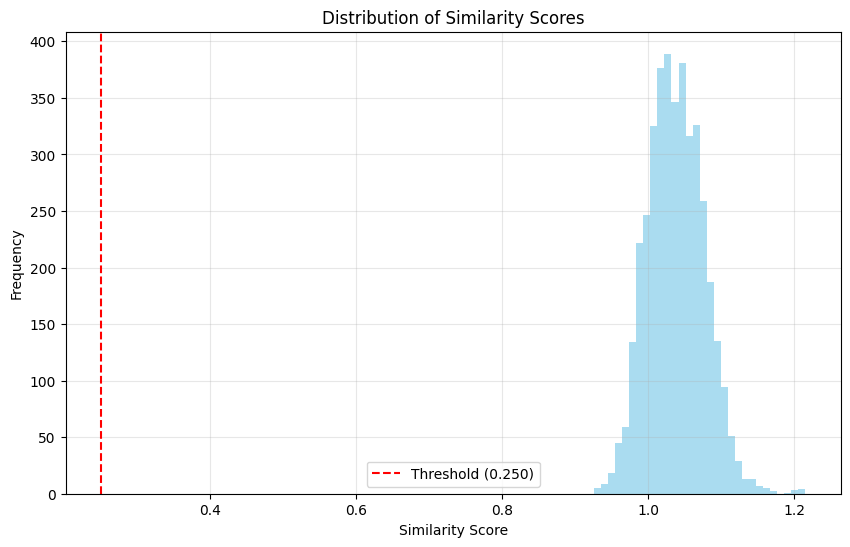


Matching summary:
- Articles with at least one match: 200 out of 200 (100.0%)
- Total article-image matches: 600
- Average images per article: 3.00

--- Step 4: Saving Results ---
Results successfully saved to /content/drive/MyDrive/Image Tagging/image_tagging_output/article_image_matches_enhanced.json
CSV results saved to /content/drive/MyDrive/Image Tagging/image_tagging_output/article_image_matches_enhanced.csv

--- Step 5: Creating Enhanced HTML Report ---
Loaded image mapping with 189 entries
HTML report saved to: /content/drive/MyDrive/Image Tagging/image_tagging_output/article_image_matches_enhanced.html

Total execution time: 348.54 seconds (5.81 minutes)


In [ ]:
# Run the complete pipeline
improved_main()

Performance Evaluation with Metadata Analysis:
---------------------------------------------
Total articles processed: 193
Articles with at least one image match: 193 (100.00%)
Total images matched: 579
Average images per article: 3.00
Average similarity score: 0.4603

Distribution of images per article:
  3 images: 193 articles (100.00%)

Image folder distribution:
  iron ore: 81 images (13.99%)
  aluminium: 78 images (13.47%)
  copper: 69 images (11.92%)
  mild steel: 59 images (10.19%)
  zinc: 57 images (9.84%)
  silico manganese: 44 images (7.60%)
  tmt: 38 images (6.56%)
  chrome ore: 27 images (4.66%)
  Crude: 27 images (4.66%)
  solar: 21 images (3.63%)
  railway infrastructure: 21 images (3.63%)
  LNG: 17 images (2.94%)
  lead: 12 images (2.07%)
  oil well: 7 images (1.21%)
  roads: 5 images (0.86%)
  steel pipe: 5 images (0.86%)
  crude oil: 4 images (0.69%)
  ss coils: 3 images (0.52%)
  solar water pumping: 2 images (0.35%)
  biodiesel: 1 images (0.17%)
  blast furnace: 1 im

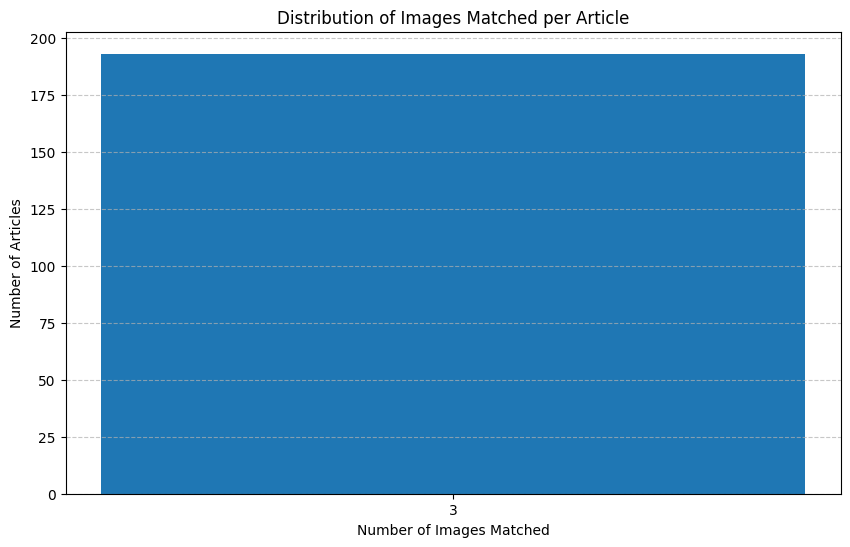

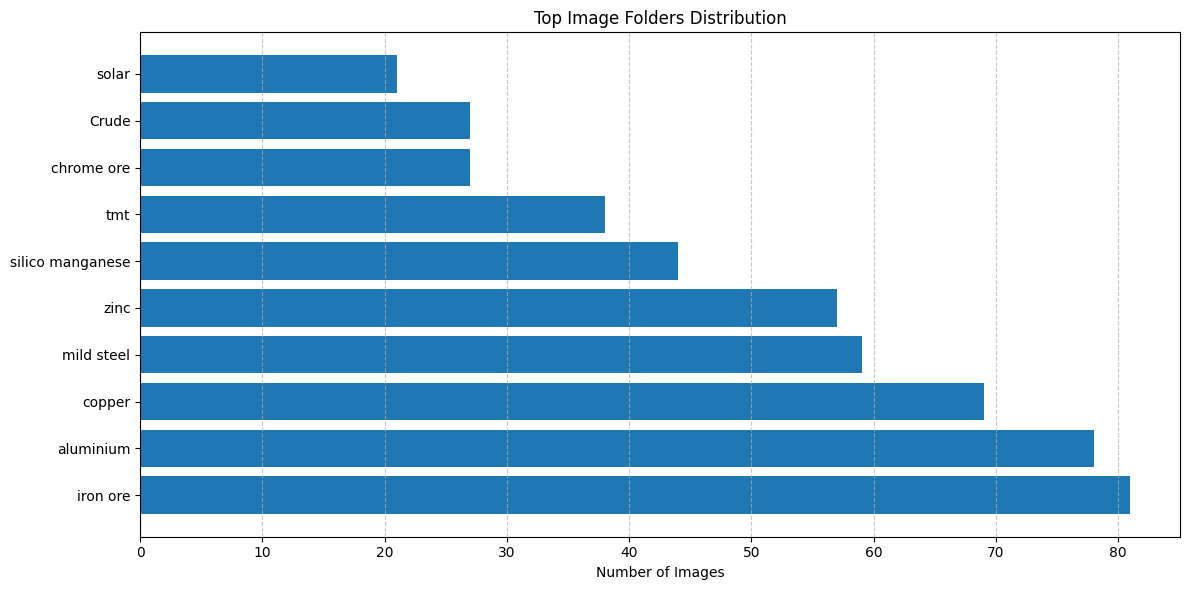

In [ ]:
# Evaluate performance
evaluate_performance()


Article: The LPR remained unchanged in April. Industry insiders predict that the policy interest rate cut in Q2 will drive the LPR down. There is room for a reduction in mortgage rates within the year.
Matched Images (3):



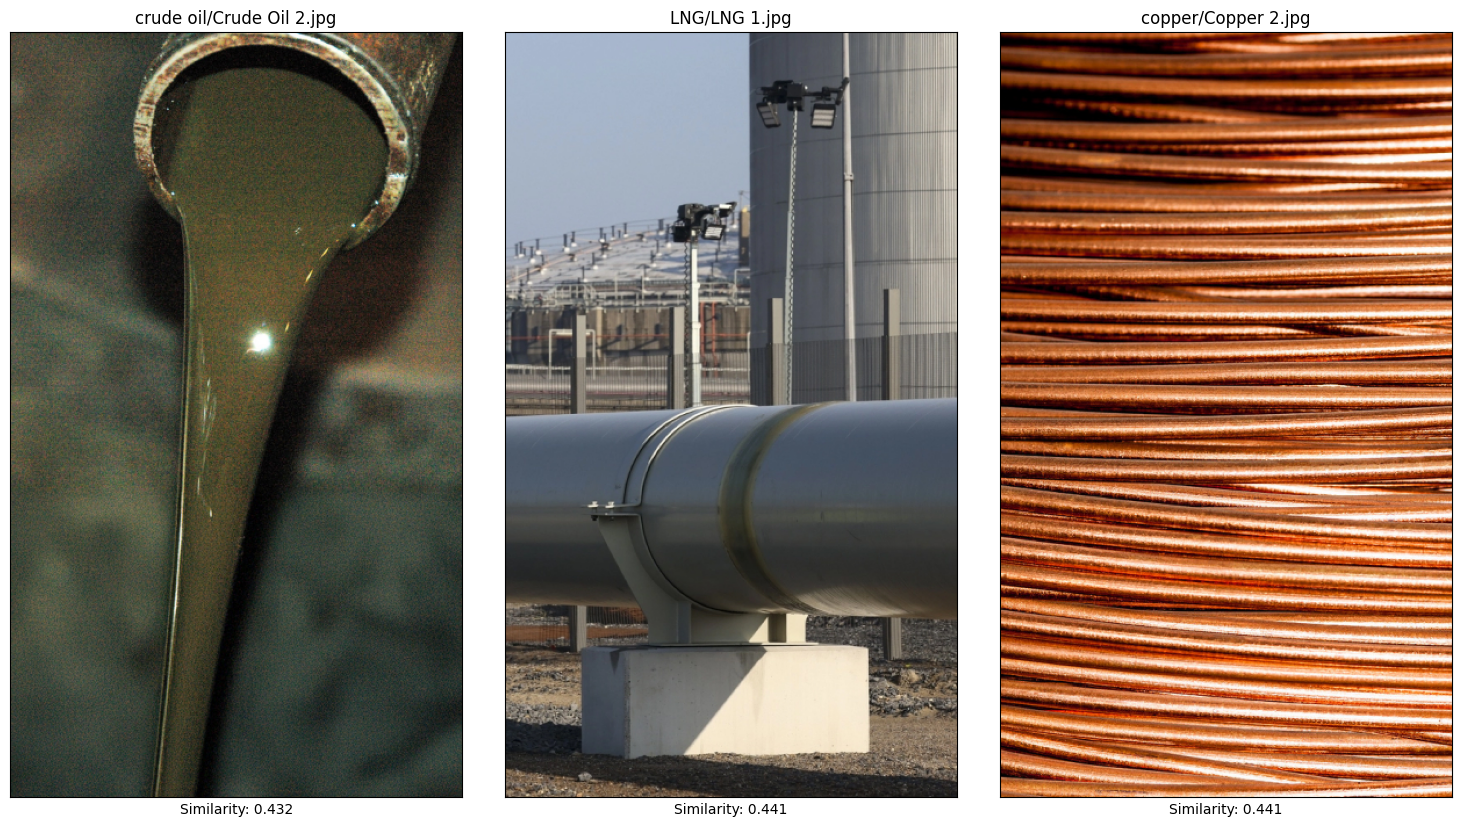


Article: Shanghai Zinc: Limited Market Supply, Spot Zinc Trading Moderate
Matched Images (3):



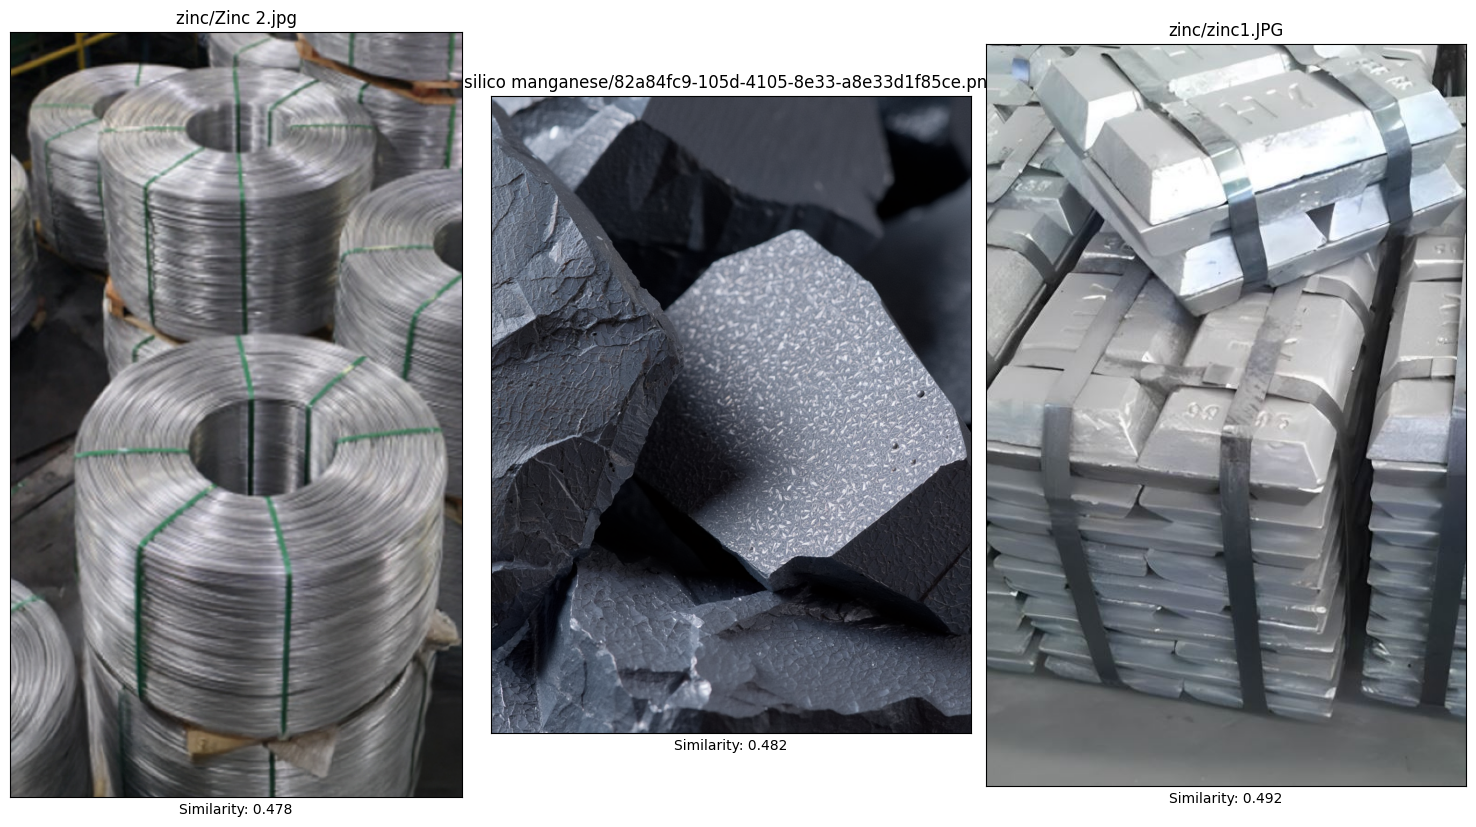


Article: At the beginning of the week, precious metals held up well, and spot supply in the Shenzhen area was relatively tight. 【SMM Daily Review】
Matched Images (3):



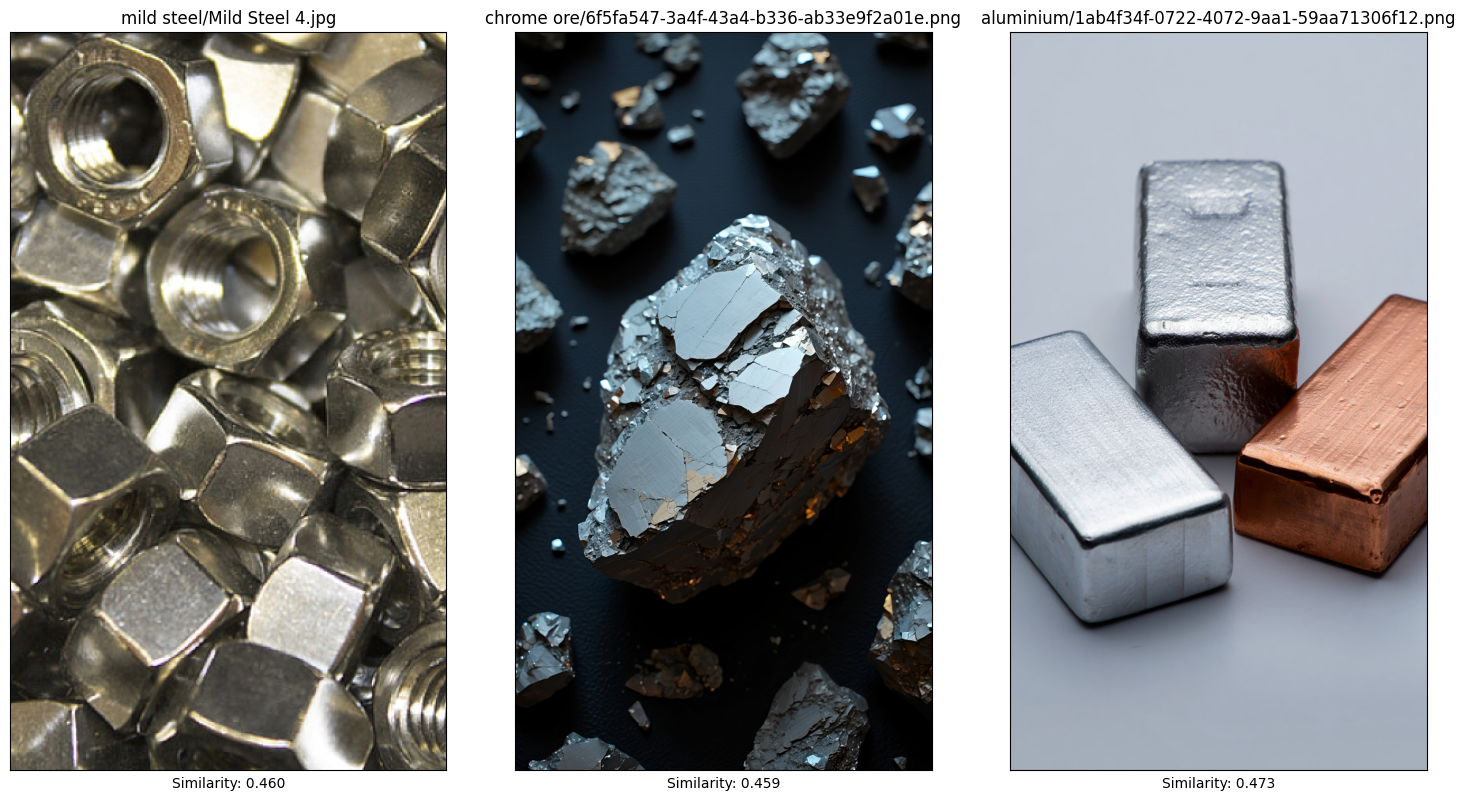

In [ ]:
# Visualize sample matches
visualize_matches(num_samples=3)